## 基于Resnet18的人脸识别（批次为32版）

In [1]:
import torch
import numpy as np  
import time
import torchvision
from sklearn.model_selection import train_test_split 
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
from torch import nn
from torch.utils import data
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from matplotlib import pyplot as plt
from IPython import display    #显示图像和动画

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

torch.cuda.is_available()

False

In [2]:
#对于任意数据迭代器data_iter可以访问的数据集，实现评估任意网络模型net的精度
def evaluate_accuracy(net,data_iter):
    """计算在指定数据集上的模型的精度"""
    if isinstance(net,torch.nn.Module):
        net.eval()  #将模型设置为评估模式
    metric = Accumulator(2) #计算正确预测的数量、预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

def accuracy(y_hat,y):
    """计算预测正确的数量"""  
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加求和"""
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data,args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]

#定义一个动画类，动态看到模型精度的变化
class Animator:
    """在动画中绘制数据"""
    def __init__(self,xlabel=None,ylabel=None,legend=None,xlim=None,ylim=None,xscale='linear',yscale='linear',
                 fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,figsize=(7,5)):
        #绘制多条曲线
        if legend is None:
            legend = []
        self.fig,self.axes = plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        #使用lambda函数捕获参数
        self.config_axes = lambda:set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)
        self.X,self.Y,self.fmts = None,None,fmts
    
    def add(self,x,y):
        #向图表中添加多个数据点
        if not hasattr(y,"__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x,"__len__"):
            x = [x] * n 
        
        if not self.X:
            self.X = [[] for _ in range(n)]        
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i,(a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        
        for x,y,fmt in zip(self.X,self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def show_images(imgs,num_rows,num_cols,titles=None,namedict=None,scale=2.5):
    figsize = (num_cols * scale,num_rows * scale)
    _,axes = plt.subplots(num_rows,num_cols,figsize=figsize)
    axes = axes.flatten()
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            img = img.numpy().transpose((1, 2, 0))
            ax.imshow(img)
        else:
            #PIL image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles is not None and namedict is not None:
#             print(titles[i].item())
#             print(namedict[str(titles[i].item())])
            ax.set_title(namedict[str(titles[i].item())])
    return axes

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""

    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [3]:
#自定义dataset，以达到处理图像的目的
class Mydataset(Dataset):
    def __init__(self,datas,labels,transform = None):
        super(Mydataset,self).__init__()
        self.data = datas
        self.label = labels
        self.transform = transform
    
    def __getitem__(self,index):
        img = self.data[index]  
        if self.transform:  
            img = self.transform(img)  
        return img, torch.tensor(self.label[index], dtype=torch.long)
    
    def __len__(self):
        return self.label.shape[0]

transform = transforms.Compose([ 
    transforms.ToPILImage(),  
    transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=224,scale=(0.5,1),ratio=(0.5,2)),   
    transforms.ToTensor(),  
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
]) 

In [4]:
data_path = "./lfw"
imgs_data = []
labels_data = []
namedict = {}
idx = 0
pathlist = list(map(lambda x: '\\'.join([data_path, x]), os.listdir(data_path)))
# print(pathlist)

for item in pathlist:
    img_list = os.listdir(item)
#     print(img_list)
    if len(img_list)>30:
        for picpath in img_list:
            img = Image.open(os.path.join(item, picpath))
            imgs_data.append(np.array(img))
            labels_data.append(idx)
            
            imgs_data.append(np.array(img))
            labels_data.append(idx)
            
        namedict[str(idx)] = item.split('\\')[-1]
        idx += 1
        namedict[str(idx)] = item.split('\\')[-1] #将每张照片加入两次以丰富数据集
        idx += 1
        
imgs_data, labels_data = np.stack(imgs_data), np.array(labels_data)
idx = np.random.permutation(imgs_data.shape[0])
data, label = imgs_data[idx], labels_data[idx]
train_X, test_X, train_Y, test_Y = train_test_split(data, label, test_size=0.2)

In [5]:
train = Mydataset(train_X,train_Y,transform=transform)
test = Mydataset(test_X,test_Y,transform=transform)

train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([<Axes: title={'center': 'Ariel_Sharon'}>,
       <Axes: title={'center': 'George_W_Bush'}>,
       <Axes: title={'center': 'George_W_Bush'}>,
       <Axes: title={'center': 'Jacques_Chirac'}>,
       <Axes: title={'center': 'Tony_Blair'}>,
       <Axes: title={'center': 'Junichiro_Koizumi'}>,
       <Axes: title={'center': 'Gerhard_Schroeder'}>,
       <Axes: title={'center': 'Megawati_Sukarnoputri'}>], dtype=object)

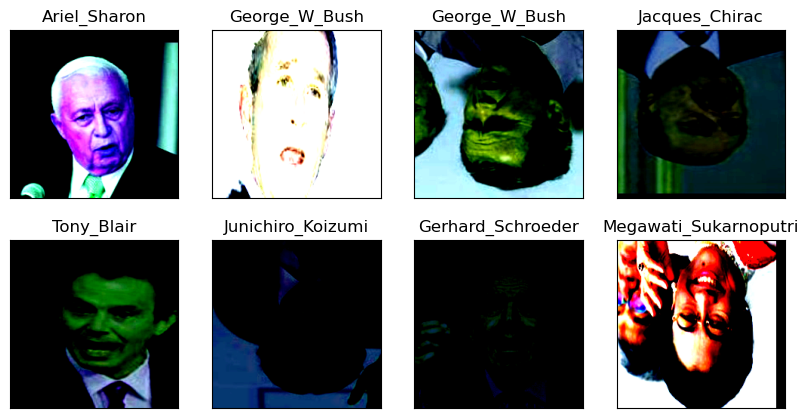

In [6]:
imgs,labels = next(iter(train_loader))
show_images(imgs,2,4,labels,namedict)

In [7]:
#确定模型及其参数（模型使用预训练的resnet18进行迁移学习，以减少训练时长）
model = models.resnet18(pretrained=True)
num_classes = len(namedict)
# 修改全连接层以符合本数据集所需要的类别数
model.fc = nn.Linear(model.fc.in_features, num_classes)

#学习率、损失函数、SGD优化器
learning_rate=0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4) #添加正则化（权重衰减）来预防可能出现的过拟合

C:\Users\15572\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\15572\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
#是否使用GPU训练
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")

In [9]:
#训练模型
def train_epoch(net, train_iter, loss, updater):  
    """实现一个迭代周期的训练过程"""  
    if isinstance(net, torch.nn.Module):  
        net.train()  # 将模型设置为训练模式  
    metric = Accumulator(3)
    for X, y in train_iter:  
        X, y = X.to(device), y.to(device) 
        y_hat = net(X)  
        loss_val = loss(y_hat, y)  
        updater.zero_grad()  
        loss_val.backward()  
        updater.step()  
        metric.add(loss_val.item(), accuracy(y_hat, y), y.numel())
  
    # 返回训练损失和训练精度  
    return metric[0] / metric[2], metric[1] / metric[2]

In [10]:
# 训练模型：该训练函数执行多个迭代周期。在每个迭代周期结束的时候使用test_iter得到的数据集评估模型。
# 使用Animator类可视化训练进度
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    loss_acc = []
    best_test_acc = 0
    patience = 3  # 设置耐心值，即连续几个 epoch 测试准确率没有提升就停止训练
    no_improvement_epochs = 0
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])

    # 记录训练开始时间
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_metric = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        train_loss, train_acc = train_metric
        loss_acc_list = {'test_acc': test_acc, 'train_loss': train_loss, 'train_acc': train_acc}
        loss_acc.append(loss_acc_list)
        animator.add(epoch + 1, train_metric + (test_acc,))

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    for epoch in range(num_epochs):
        print('epoch ：{}'.format(epoch + 1))
        print('train_loss ：{:.3f}%'.format(loss_acc[epoch].get('train_loss') * 100))  #保留三位小数
        print('train_acc ：{:.3f}%'.format(loss_acc[epoch].get('train_acc') * 100))
        print('test_acc ：{:.3f}%\n'.format(loss_acc[epoch].get('test_acc') * 100))

    # 打印最终结果
    print("Final train loss: {:.3f}% ".format(train_loss * 100))
    print("Final train accuracy: {:.3f}%".format(train_acc * 100))
    print("Final test accuracy: {:.3f}%".format(test_acc * 100))
    # 记录训练结束时间
    end_time = time.time()
    training_duration = end_time - start_time
    # 判断并输出训练设备
    if torch.cuda.is_available():
        print(f"训练在 GPU 上完成，耗时：{training_duration:.2f} 秒。")
    else:
        print(f"训练在 CPU 上完成，耗时：{training_duration:.2f} 秒。")
    torch.save(model, "recognition.pth") #保存模型

epoch ：1
train_loss ：9.005%
train_acc ：29.266%
test_acc ：40.737%

epoch ：2
train_loss ：6.021%
train_acc ：51.576%
test_acc ：59.375%

epoch ：3
train_loss ：4.123%
train_acc ：68.016%
test_acc ：71.429%

epoch ：4
train_loss ：2.828%
train_acc ：79.103%
test_acc ：81.027%

epoch ：5
train_loss ：2.026%
train_acc ：85.326%
test_acc ：85.714%

epoch ：6
train_loss ：1.532%
train_acc ：89.348%
test_acc ：87.612%

epoch ：7
train_loss ：1.168%
train_acc ：91.957%
test_acc ：89.286%

epoch ：8
train_loss ：1.013%
train_acc ：93.397%
test_acc ：89.732%

epoch ：9
train_loss ：0.799%
train_acc ：94.864%
test_acc ：93.192%

epoch ：10
train_loss ：0.711%
train_acc ：95.190%
test_acc ：92.634%

epoch ：11
train_loss ：0.605%
train_acc ：96.033%
test_acc ：93.304%

epoch ：12
train_loss ：0.518%
train_acc ：96.739%
test_acc ：93.638%

epoch ：13
train_loss ：0.480%
train_acc ：96.386%
test_acc ：95.424%

epoch ：14
train_loss ：0.416%
train_acc ：97.283%
test_acc ：96.429%

epoch ：15
train_loss ：0.371%
train_acc ：97.772%
test_acc ：95.424%

Fina

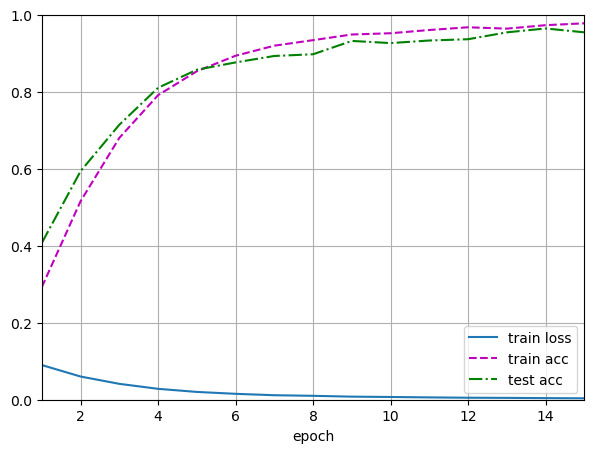

In [11]:
num_epochs = 15
train(model,train_loader,test_loader,criterion,num_epochs,optimizer)